# Building scenarios

Pymagicc offers the ability to join/merge scenarios to create custom scenarios. Here we show a minimal working example of how to do this.

In [1]:
# NBVAL_IGNORE_OUTPUT
from os.path import join
from datetime import datetime

import pandas as pd

from pymagicc import MAGICC6
from pymagicc.io import MAGICCData
from pymagicc.definitions import (
    convert_magicc7_to_openscm_variables,
    PART_OF_SCENFILE_WITH_EMISSIONS_CODE_1,
)
from scmdata import run_append

import expectexception

import matplotlib.pyplot as plt

plt.style.use("bmh")
%matplotlib inline

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


In [2]:
DATA_DIR = join("..", "tests", "test_data")
DATA_MAGICC6_RUN = join("..", "pymagicc", "MAGICC6", "run")

We start by reading in our raw data. As the formats we're reading don't have any easily readable metadata, we set it using the `columns` argument. 

**Note**: The `model` column refers to the model which generated the scenario (typically an integrated assessment model), with the `climate_model` column being saved for storing the climate model which was used to do climate projections.

In [3]:
rcp3pd = MAGICCData(
    join(DATA_DIR, "RCP3PD_EMISSIONS.DAT"),
    columns={"model": "IMAGE", "scenario": "RCP3PD"},
)
rcp3pd.head()

time                                                                                                               1765-01-01 00:00:00  \
climate_model                  model region scenario todo unit         variable                                                          
MAGICC6.3.09, 25 November 2009 IMAGE World  RCP3PD   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial                0.003   
                                                                       Emissions|CO2|MAGICC AFOLU                                0.000   
                                                          Mt CH4 / yr  Emissions|CH4                                             0.000   
                                                          Mt N2ON / yr Emissions|N2O                                             0.000   
                                                          Mt S / yr    Emissions|SOx                                             0.000   

time                                                                                                               1766-01-01 00:00:00  \
climate_model                  model region scenario todo unit         variable                                                          
MAGICC6.3.09, 25 November 2009 IMAGE World  RCP3PD   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                                                       Emissions|CO2|MAGICC AFOLU                             0.005338   
                                                          Mt CH4 / yr  Emissions|CH4                                          1.963262   
                                                          Mt N2ON / yr Emissions|N2O                                          0.005191   
                                                          Mt S / yr    Emissions|SOx                                          0.098883   

time                                                                                                               1767-01-01 00:00:00  \
climate_model                  model region scenario todo unit         variable                                                          
MAGICC6.3.09, 25 November 2009 IMAGE World  RCP3PD   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                                                       Emissions|CO2|MAGICC AFOLU                             0.010677   
                                                          Mt CH4 / yr  Emissions|CH4                                          2.436448   
                                                          Mt N2ON / yr Emissions|N2O                                          0.010117   
                                                          Mt S / yr    Emissions|SOx                                          0.116306   

time                                                                                                               1768-01-01 00:00:00  \
climate_model                  model region scenario todo unit         variable                                                          
MAGICC6.3.09, 25 November 2009 IMAGE World  RCP3PD   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                                                       Emissions|CO2|MAGICC AFOLU                             0.016015   
                                                          Mt CH4 / yr  Emissions|CH4                                          2.911105   
                                                          Mt N2ON / yr Emissions|N2O                                          0.015043   
                                                          Mt S / yr    Emissions|SOx                                          0.133811   

time                                                                                                               1769-01-01 00:00:

This data came from MAGICC6.3.09, in order to set it up for a new run, we have to strip out that information.

In [4]:
rcp3pd["climate_model"] = "unspecified"
rcp3pd.head()

time                                                                                              1765-01-01 00:00:00  \
climate_model model region scenario todo unit         variable                                                          
unspecified   IMAGE World  RCP3PD   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial                0.003   
                                                      Emissions|CO2|MAGICC AFOLU                                0.000   
                                         Mt CH4 / yr  Emissions|CH4                                             0.000   
                                         Mt N2ON / yr Emissions|N2O                                             0.000   
                                         Mt S / yr    Emissions|SOx                                             0.000   

time                                                                                              1766-01-01 00:00:00  \
climate_model model region scenario todo unit         variable                                                          
unspecified   IMAGE World  RCP3PD   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                                      Emissions|CO2|MAGICC AFOLU                             0.005338   
                                         Mt CH4 / yr  Emissions|CH4                                          1.963262   
                                         Mt N2ON / yr Emissions|N2O                                          0.005191   
                                         Mt S / yr    Emissions|SOx                                          0.098883   

time                                                                                              1767-01-01 00:00:00  \
climate_model model region scenario todo unit         variable                                                          
unspecified   IMAGE World  RCP3PD   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                                      Emissions|CO2|MAGICC AFOLU                             0.010677   
                                         Mt CH4 / yr  Emissions|CH4                                          2.436448   
                                         Mt N2ON / yr Emissions|N2O                                          0.010117   
                                         Mt S / yr    Emissions|SOx                                          0.116306   

time                                                                                              1768-01-01 00:00:00  \
climate_model model region scenario todo unit         variable                                                          
unspecified   IMAGE World  RCP3PD   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                                      Emissions|CO2|MAGICC AFOLU                             0.016015   
                                         Mt CH4 / yr  Emissions|CH4                                          2.911105   
                                         Mt N2ON / yr Emissions|N2O                                          0.015043   
                                         Mt S / yr    Emissions|SOx                                          0.133811   

time                                                                                              1769-01-01 00:00:00  \
climate_model model region scenario todo unit         variable                                                          
unspecified   IMAGE World  RCP3PD   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                                      Emissions|CO2|MAGICC AFOLU                             0.021353   
                                         Mt CH4 / yr  Emissions|CH4                                          3.387278   
   

In [5]:
rcp85 = MAGICCData(
    join(DATA_MAGICC6_RUN, "RCP85.SCEN"),
    columns={"model": "MESSAGE", "scenario": "RCP85"},
)
rcp85["climate_model"] = "unspecified"
rcp85.head()

time                                                                                                       2000-01-01 00:00:00  \
climate_model model   region        scenario todo unit         variable                                                          
unspecified   MESSAGE World|Bunkers RCP85    SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial               0.0000   
                                                               Emissions|CO2|MAGICC AFOLU                               0.0000   
                                                  Mt CH4 / yr  Emissions|CH4                                            0.4325   
                                                  Mt N2ON / yr Emissions|N2O                                            0.0000   
                                                  Mt S / yr    Emissions|SOx                                            5.5390   

time                                                                                                       2001-01-01 00:00:00  \
climate_model model   region        scenario todo unit         variable                                                          
unspecified   MESSAGE World|Bunkers RCP85    SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial               0.0000   
                                                               Emissions|CO2|MAGICC AFOLU                               0.0000   
                                                  Mt CH4 / yr  Emissions|CH4                                            0.4422   
                                                  Mt N2ON / yr Emissions|N2O                                            0.0000   
                                                  Mt S / yr    Emissions|SOx                                            5.5824   

time                                                                                                       2002-01-01 00:00:00  \
climate_model model   region        scenario todo unit         variable                                                          
unspecified   MESSAGE World|Bunkers RCP85    SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial               0.0000   
                                                               Emissions|CO2|MAGICC AFOLU                               0.0000   
                                                  Mt CH4 / yr  Emissions|CH4                                            0.4520   
                                                  Mt N2ON / yr Emissions|N2O                                            0.0000   
                                                  Mt S / yr    Emissions|SOx                                            5.6207   

time                                                                                                       2003-01-01 00:00:00  \
climate_model model   region        scenario todo unit         variable                                                          
unspecified   MESSAGE World|Bunkers RCP85    SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial               0.0000   
                                                               Emissions|CO2|MAGICC AFOLU                               0.0000   
                                                  Mt CH4 / yr  Emissions|CH4                                            0.4618   
                                                  Mt N2ON / yr Emissions|N2O                                            0.0000   
                                                  Mt S / yr    Emissions|SOx                                            5.6587   

time                                                                                                       2004-01-01 00:00:00  \
climate_model model   region        scenario todo unit         variable                                                          
unspecified   MESSAGE World|Bunkers RCP85    SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and I

To join the data, we first have to do a little bit of preparation. Specifically, we must make sure that the metadata for the timeseries we want to prepare is the same which means re-writing the model and scenario columns.

In [6]:
my_scen_hist = rcp3pd.copy()
my_scen_hist["model"] = "idealised"
my_scen_hist["scenario"] = "custom"

my_scen_future = rcp85.copy()
my_scen_future["model"] = "idealised"
my_scen_future["scenario"] = "custom"

my_scen_future.tail()

time                                                                              2000-01-01 00:00:00  \
climate_model model     region scenario todo unit             variable                                  
unspecified   idealised World  custom   SET  kt HFC134a / yr  Emissions|HFC134a               75.0394   
                                             kt HFC143a / yr  Emissions|HFC143a                6.2341   
                                             kt HFC227ea / yr Emissions|HFC227ea               1.9510   
                                             kt HFC245fa / yr Emissions|HFC245fa              17.9257   
                                             kt SF6 / yr      Emissions|SF6                    5.5382   

time                                                                              2001-01-01 00:00:00  \
climate_model model     region scenario todo unit             variable                                  
unspecified   idealised World  custom   SET  kt HFC134a / yr  Emissions|HFC134a               84.0409   
                                             kt HFC143a / yr  Emissions|HFC143a                7.4947   
                                             kt HFC227ea / yr Emissions|HFC227ea               1.6450   
                                             kt HFC245fa / yr Emissions|HFC245fa              19.7183   
                                             kt SF6 / yr      Emissions|SF6                    5.6990   

time                                                                              2002-01-01 00:00:00  \
climate_model model     region scenario todo unit             variable                                  
unspecified   idealised World  custom   SET  kt HFC134a / yr  Emissions|HFC134a               94.7162   
                                             kt HFC143a / yr  Emissions|HFC143a                8.7389   
                                             kt HFC227ea / yr Emissions|HFC227ea               2.5080   
                                             kt HFC245fa / yr Emissions|HFC245fa              21.5109   
                                             kt SF6 / yr      Emissions|SF6                    5.8596   

time                                                                              2003-01-01 00:00:00  \
climate_model model     region scenario todo unit             variable                                  
unspecified   idealised World  custom   SET  kt HFC134a / yr  Emissions|HFC134a              101.4157   
                                             kt HFC143a / yr  Emissions|HFC143a                9.9776   
                                             kt HFC227ea / yr Emissions|HFC227ea               3.3410   
                                             kt HFC245fa / yr Emissions|HFC245fa              23.3034   
                                             kt SF6 / yr      Emissions|SF6                    6.0202   

time                                                                              2004-01-01 00:00:00  \
climate_model model     region scenario todo unit             variable                                  
unspecified   idealised World  custom   SET  kt HFC134a / yr  Emissions|HFC134a              113.9297   
                                             kt HFC143a / yr  Emissions|HFC143a               11.2136   
                                             kt HFC227ea / yr Emissions|HFC227ea               4.2690   
                                             kt HFC245fa / yr Emissions|HFC245fa              25.0960   
                                             kt SF6 / yr      Emissions|SF6                    6.1806   

time                                                                              2005-01-01 00:00:00  \
climate_model model     region scenario todo unit             variable                                  
unspecified   idealised World  custom   SET  kt HFC134a / yr  Emissions|HFC134a              120.9334   
     

To then join the data, we can simply filter the data and then append one onto the other. 

In [7]:
# NBVAL_IGNORE_OUTPUT
my_scen_hist.filter(year=range(1, 2006)).head()

time                                                                                                  1765-01-01  \
climate_model model     region scenario todo unit         variable                                                 
unspecified   idealised World  custom   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial       0.003   
                                                          Emissions|CO2|MAGICC AFOLU                       0.000   
                                             Mt CH4 / yr  Emissions|CH4                                    0.000   
                                             Mt N2ON / yr Emissions|N2O                                    0.000   
                                             Mt S / yr    Emissions|SOx                                    0.000   

time                                                                                                  1766-01-01  \
climate_model model     region scenario todo unit         variable                                                 
unspecified   idealised World  custom   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial    0.003000   
                                                          Emissions|CO2|MAGICC AFOLU                    0.005338   
                                             Mt CH4 / yr  Emissions|CH4                                 1.963262   
                                             Mt N2ON / yr Emissions|N2O                                 0.005191   
                                             Mt S / yr    Emissions|SOx                                 0.098883   

time                                                                                                  1767-01-01  \
climate_model model     region scenario todo unit         variable                                                 
unspecified   idealised World  custom   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial    0.003000   
                                                          Emissions|CO2|MAGICC AFOLU                    0.010677   
                                             Mt CH4 / yr  Emissions|CH4                                 2.436448   
                                             Mt N2ON / yr Emissions|N2O                                 0.010117   
                                             Mt S / yr    Emissions|SOx                                 0.116306   

time                                                                                                  1768-01-01  \
climate_model model     region scenario todo unit         variable                                                 
unspecified   idealised World  custom   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial    0.003000   
                                                          Emissions|CO2|MAGICC AFOLU                    0.016015   
                                             Mt CH4 / yr  Emissions|CH4                                 2.911105   
                                             Mt N2ON / yr Emissions|N2O                                 0.015043   
                                             Mt S / yr    Emissions|SOx                                 0.133811   

time                                                                                                  1769-01-01  \
climate_model model     region scenario todo unit         variable                                                 
unspecified   idealised World  custom   SET  Gt C / yr    Emissions|CO2|MAGICC Fossil and Industrial    0.003000   
                                                          Emissions|CO2|MAGICC AFOLU                    0.021353   
                                             Mt CH4 / yr  Emissions|CH4                                 3.387278   
                                             Mt N2ON / yr Emissions|N2O                                 0.019969   
                                             Mt S / 

In [8]:
# NBVAL_IGNORE_OUTPUT
rcp3pd_up_to_2005 = my_scen_hist.filter(year=range(1, 2006))
rcp85_2006_onwards = my_scen_future.filter(year=range(2006, 30000))
# TODO: fix openscm method so it checks for duplicate time points, not duplicate index...
my_scen = rcp3pd_up_to_2005.append(rcp85_2006_onwards, duplicate_msg="warn")
my_scen["time"].head()

0    1765-01-01 00:00:00
1    1766-01-01 00:00:00
2    1767-01-01 00:00:00
3    1768-01-01 00:00:00
4    1769-01-01 00:00:00
Name: time, dtype: object

In [9]:
# NBVAL_IGNORE_OUTPUT
my_scen["time"].tail()

261    2300-01-01 00:00:00
262    2350-01-01 00:00:00
263    2400-01-01 00:00:00
264    2450-01-01 00:00:00
265    2500-01-01 00:00:00
Name: time, dtype: object

Note that appending in this way keeps all of the available data. This means that we still have regional data over the future.

In [10]:
# NBVAL_IGNORE_OUTPUT
my_scen.filter(region="World", keep=False).head()

time                                                                                                        1765-01-01 00:00:00  \
climate_model model     region        scenario todo unit        variable                                                          
unspecified   idealised World|Bunkers custom   SET  Gt C / yr   Emissions|CO2|MAGICC AFOLU                                  NaN   
                                                                Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                                    Mt BC / yr  Emissions|BC                                                NaN   
                                                    Mt CH4 / yr Emissions|CH4                                               NaN   
                                                    Mt CO / yr  Emissions|CO                                                NaN   

time                                                                                                        1766-01-01 00:00:00  \
climate_model model     region        scenario todo unit        variable                                                          
unspecified   idealised World|Bunkers custom   SET  Gt C / yr   Emissions|CO2|MAGICC AFOLU                                  NaN   
                                                                Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                                    Mt BC / yr  Emissions|BC                                                NaN   
                                                    Mt CH4 / yr Emissions|CH4                                               NaN   
                                                    Mt CO / yr  Emissions|CO                                                NaN   

time                                                                                                        1767-01-01 00:00:00  \
climate_model model     region        scenario todo unit        variable                                                          
unspecified   idealised World|Bunkers custom   SET  Gt C / yr   Emissions|CO2|MAGICC AFOLU                                  NaN   
                                                                Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                                    Mt BC / yr  Emissions|BC                                                NaN   
                                                    Mt CH4 / yr Emissions|CH4                                               NaN   
                                                    Mt CO / yr  Emissions|CO                                                NaN   

time                                                                                                        1768-01-01 00:00:00  \
climate_model model     region        scenario todo unit        variable                                                          
unspecified   idealised World|Bunkers custom   SET  Gt C / yr   Emissions|CO2|MAGICC AFOLU                                  NaN   
                                                                Emissions|CO2|MAGICC Fossil and Industrial                  NaN   
                                                    Mt BC / yr  Emissions|BC                                                NaN   
                                                    Mt CH4 / yr Emissions|CH4                                               NaN   
                                                    Mt CO / yr  Emissions|CO                                                NaN   

time                                                                                                        1769-01-01 00:00:00  \
climate_model model     region        scenario todo unit        variable                                                          
unspecified   idealised World|Bunkers custom   SET  Gt C / yr   Em

We can remove this by simply filtering our scenario once again.

In [11]:
# NBVAL_IGNORE_OUTPUT
my_scen_world = my_scen.filter(region="World")
my_scen_world.head()

time                                                                                                 1765-01-01 00:00:00  \
climate_model model     region scenario todo unit        variable                                                          
unspecified   idealised World  custom   SET  Gt C / yr   Emissions|CO2|MAGICC AFOLU                                0.000   
                                                         Emissions|CO2|MAGICC Fossil and Industrial                0.003   
                                             Mt BC / yr  Emissions|BC                                              0.000   
                                             Mt CH4 / yr Emissions|CH4                                             0.000   
                                             Mt CO / yr  Emissions|CO                                              0.000   

time                                                                                                 1766-01-01 00:00:00  \
climate_model model     region scenario todo unit        variable                                                          
unspecified   idealised World  custom   SET  Gt C / yr   Emissions|CO2|MAGICC AFOLU                             0.005338   
                                                         Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                             Mt BC / yr  Emissions|BC                                           0.106998   
                                             Mt CH4 / yr Emissions|CH4                                          1.963262   
                                             Mt CO / yr  Emissions|CO                                           9.050221   

time                                                                                                 1767-01-01 00:00:00  \
climate_model model     region scenario todo unit        variable                                                          
unspecified   idealised World  custom   SET  Gt C / yr   Emissions|CO2|MAGICC AFOLU                             0.010677   
                                                         Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                             Mt BC / yr  Emissions|BC                                           0.133383   
                                             Mt CH4 / yr Emissions|CH4                                          2.436448   
                                             Mt CO / yr  Emissions|CO                                          12.960844   

time                                                                                                 1768-01-01 00:00:00  \
climate_model model     region scenario todo unit        variable                                                          
unspecified   idealised World  custom   SET  Gt C / yr   Emissions|CO2|MAGICC AFOLU                             0.016015   
                                                         Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                                             Mt BC / yr  Emissions|BC                                           0.159847   
                                             Mt CH4 / yr Emissions|CH4                                          2.911105   
                                             Mt CO / yr  Emissions|CO                                          16.876539   

time                                                                                                 1769-01-01 00:00:00  \
climate_model model     region scenario todo unit        variable                                                          
unspecified   idealised World  custom   SET  Gt C / yr   Emissions|CO2|MAGICC AFOLU                             0.021353   
                                                         Emissions|CO2|MAGICC Fossil and Industrial             0.003000   
                            

We can check the results as shown.

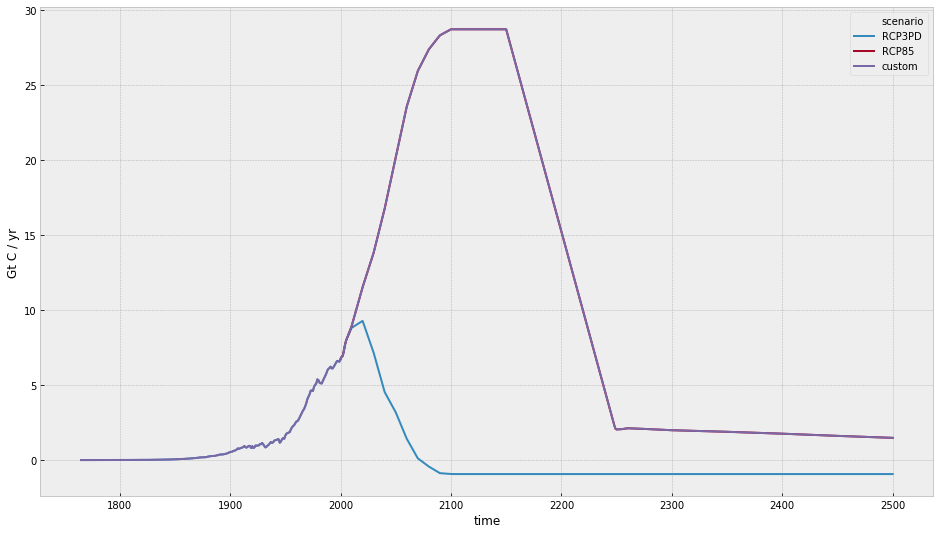

In [12]:
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

plt.figure(figsize=(16, 9))

run_append([rcp3pd, rcp85, my_scen_world]).filter(
    region="World", variable=var_to_plot
).lineplot(x="time", hue="scenario");

If we put our scenario into a MAGICCData object, we can run it using Pymagicc.

Note that Pymagicc automatically only uses the variables which are in SCEN files.

In [13]:
with MAGICC6() as magicc:
    results = magicc.run()

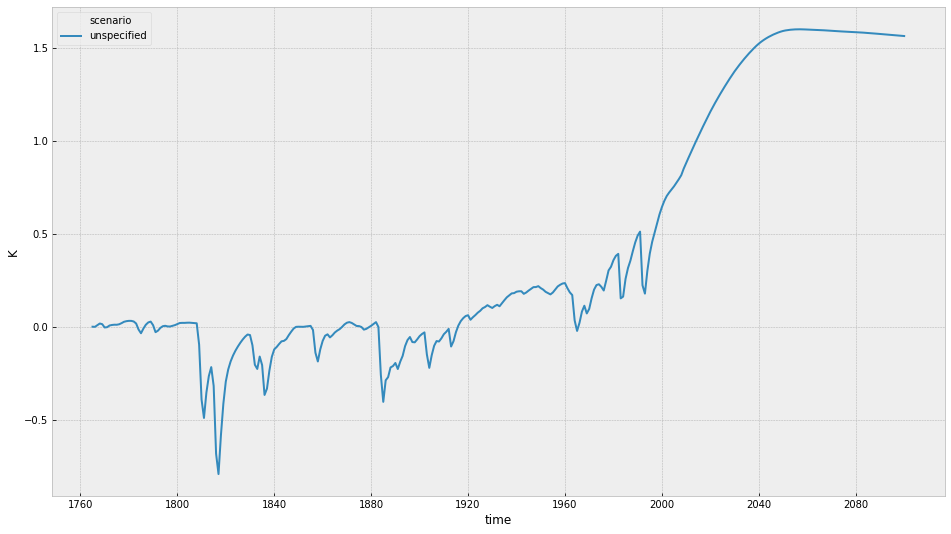

In [14]:
plt.figure(figsize=(16, 9))
results.filter(variable="Surface Temperature", region="World").lineplot(
    x="time"
);

If we wish, we can also `MAGICCData`'s resample method to join our timeseries together with a linear interpolation over a given period. This allows us to use some base scenario, overwrite with a multitude of other scenarios but ensure they all have a common historical period and some roughly smooth transition. (At the moment the `resample` and `interpolate` methods are the only options, a far more complete solution would be to use the [Aneris](https://github.com/iiasa/aneris) package but this would also be far more difficult.)

In [15]:
rcp3pd_up_to_2005 = my_scen_hist.filter(year=range(1, 2006))
rcp85_2015_onwards = my_scen_future.filter(year=range(2015, 30000))

linear_scen = (
    rcp3pd_up_to_2005.append(rcp85_2015_onwards, duplicate_msg="warn")
    .filter(region="World")
    .resample("AS")
)

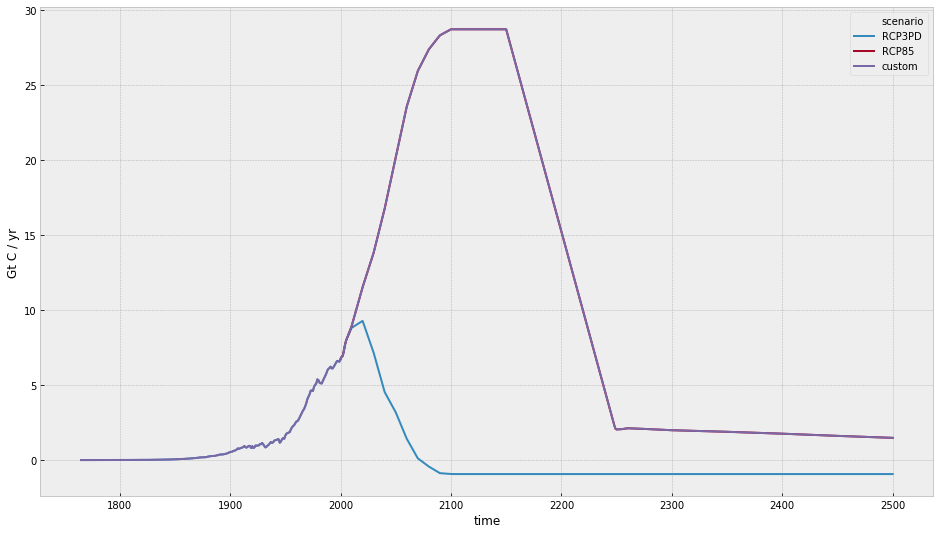

In [16]:
var_to_plot = "Emissions|CO2|MAGICC Fossil and Industrial"

plt.figure(figsize=(16, 9))
run_append([rcp3pd, rcp85, my_scen_world]).filter(
    region="World", variable=var_to_plot
).lineplot(x="time", hue="scenario");

In [17]:
with MAGICC6() as magicc:
    results = magicc.run(linear_scen)

/home/jared/code/uom/pymagicc/pymagicc/io/scen.py:254: UserWarning: Ignoring input data which is not required for .SCEN file
  warnings.warn("Ignoring input data which is not required for .SCEN file")


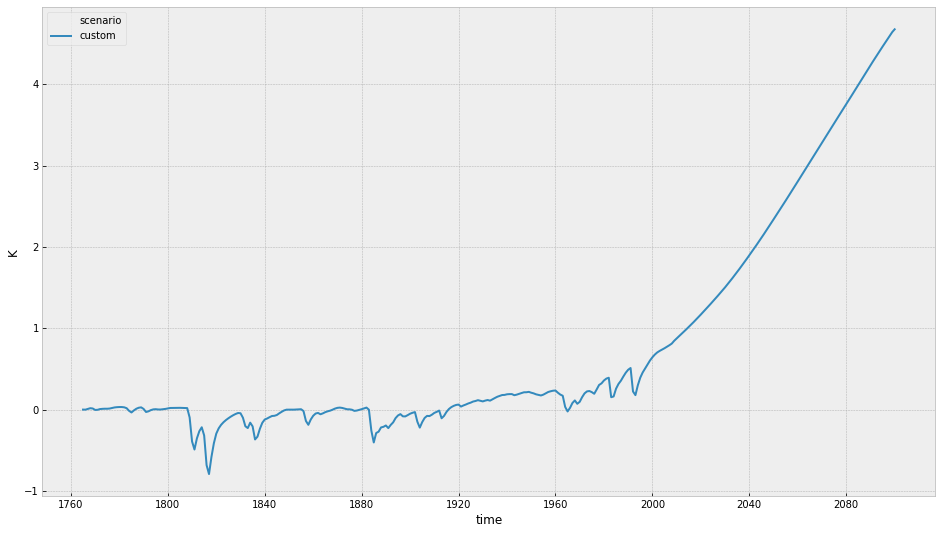

In [18]:
plt.figure(figsize=(16, 9))
results.filter(variable="Surface Temperature", region="World").line_plot(
    x="time",
);

## Warning

If you try to merge data which has no overlapping indices, you'll end up with `np.nan` in your output. For example, if we set our "todo" column to "N/A" in `base` (for an explanation of what this "todo" column is, see [file conventions](https://pymagicc.readthedocs.io/en/latest/file_conventions.html#columns)).

As a user, you have to check carefully that the merging has actually happened as intended (pull requests with convenience functions that can help automate these checks are most welcome!!). One easy way to do this is to simply see if any of the data in the output is null.

In [19]:
rcp85_2015_onwards_world = my_scen_future.filter(
    year=range(2015, 30000), region="World",
)
rcp3pd_up_to_2005_world = my_scen_hist.filter(
    year=range(1, 2006), region="World",
)

null_output = rcp3pd_up_to_2005_world.append(
    rcp85_2015_onwards_world, duplicate_msg="warn"
).timeseries()
null_output.isnull().any().any()

True

There are still null values, we can see where they are with something like this.

In [20]:
# NBVAL_IGNORE_OUTPUT
null_output[null_output.isnull().any(axis=1)]

time                                                                                1765-01-01 00:00:00  \
climate_model model     region scenario todo unit              variable                                   
unspecified   idealised World  custom   SET  kt CCl4 / yr      Emissions|CCl4                     0.000   
                                             kt CFC11 / yr     Emissions|CFC11                    0.000   
                                             kt CFC113 / yr    Emissions|CFC113                   0.000   
                                             kt CFC114 / yr    Emissions|CFC114                   0.000   
                                             kt CFC115 / yr    Emissions|CFC115                   0.000   
                                             kt CFC12 / yr     Emissions|CFC12                    0.000   
                                             kt CH3Br / yr     Emissions|CH3Br                  157.267   
                                             kt CH3CCl3 / yr   Emissions|CH3CCl3                  0.000   
                                             kt CH3Cl / yr     Emissions|CH3Cl                 3100.211   
                                             kt HCFC141b / yr  Emissions|HCFC141b                 0.000   
                                             kt HCFC142b / yr  Emissions|HCFC142b                 0.000   
                                             kt HCFC22 / yr    Emissions|HCFC22                   0.000   
                                             kt Halon1202 / yr Emissions|Halon1202                0.000   
                                             kt Halon1211 / yr Emissions|Halon1211                0.000   
                                             kt Halon1301 / yr Emissions|Halon1301                0.000   
                                             kt Halon2402 / yr Emissions|Halon2402                0.000   

time                                                                                1766-01-01 00:00:00  \
climate_model model     region scenario todo unit              variable                                   
unspecified   idealised World  custom   SET  kt CCl4 / yr      Emissions|CCl4                     0.000   
                                             kt CFC11 / yr     Emissions|CFC11                    0.000   
                                             kt CFC113 / yr    Emissions|CFC113                   0.000   
                                             kt CFC114 / yr    Emissions|CFC114                   0.000   
                                             kt CFC115 / yr    Emissions|CFC115                   0.000   
                                             kt CFC12 / yr     Emissions|CFC12                    0.000   
                                             kt CH3Br / yr     Emissions|CH3Br                  157.267   
                                             kt CH3CCl3 / yr   Emissions|CH3CCl3                  0.000   
                                             kt CH3Cl / yr     Emissions|CH3Cl                 3100.211   
                                             kt HCFC141b / yr  Emissions|HCFC141b                 0.000   
                                             kt HCFC142b / yr  Emissions|HCFC142b                 0.000   
                                             kt HCFC22 / yr    Emissions|HCFC22                   0.000   
                                             kt Halon1202 / yr Emissions|Halon1202                0.000   
                                             kt Halon1211 / yr Emissions|Halon1211                0.000   
                                             kt Halon1301 / yr Emissions|Halon1301                0.000   
                                             kt Halon2402 / yr Emissions|Halon2402                0.000   

time                                                                                1767-01-01 00:00:00  \
climate_model model     region scenario

This makes it clear that all of the non-SCEN gases have `np.nan` values into the future, which makes sense as the SCEN file does not define them. 

If we drop these variables first, i.e. do the merge carefully, none of the null values appear.

In [21]:
rcp85_2015_onwards_world = my_scen_future.filter(
    year=range(2015, 30000), region="World"
)
rcp3pd_up_to_2005_world_careful = my_scen_hist.filter(
    year=range(1, 2006),
    region="World",
    variable=rcp85_2015_onwards_world["variable"],
)

no_nulls = rcp3pd_up_to_2005_world_careful.append(
    rcp85_2015_onwards_world, duplicate_msg="warn"
)
no_nulls.timeseries().isnull().any().any()

False

As a side effect, running MAGICC with this scenario does not produce any warning about ignoring data.

In [22]:
with MAGICC6() as magicc:
    results = magicc.run(linear_scen)